In [468]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import json
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import OPTICS
from numpy import quantile, where, random
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/weather-data-1940-2023-daily/data_2023-05-26.json


We will be performing outlier/novelty detection on weather data for 7 Cities around the world.

In [25]:
with open('/kaggle/input/weather-data-1940-2023-daily/data_2023-05-26.json', "r") as file:
    data_json = json.load(file) 

#Load every city as a list of dicts
data_parsed = []
for city in data_json:
    data_parsed.append(json.loads(city))

Since our dataset is quite large, we need a tool to figure out the structure of the JSON before we proceed.

In [26]:
def display_json_keys(data, indent=0):
    if isinstance(data, dict):
        print(f"{' ' * indent}Dictionary:")
        indent+=2
        for key in data.keys():
            print(f"{' ' * indent}{key}:")
            display_json_keys(data[key], indent + 2)
    elif isinstance(data, list):
        print(f"{' ' * indent}List:")
        indent+=2
        for item in data:
            display_json_keys(item, indent)
            break
display_json_keys(data_parsed)

List:
  Dictionary:
    latitude:
    longitude:
    generationtime_ms:
    utc_offset_seconds:
    timezone:
    timezone_abbreviation:
    elevation:
    daily_units:
      Dictionary:
        time:
        weathercode:
        temperature_2m_max:
        temperature_2m_min:
        temperature_2m_mean:
        apparent_temperature_max:
        apparent_temperature_min:
        apparent_temperature_mean:
        precipitation_sum:
        rain_sum:
        snowfall_sum:
        windspeed_10m_max:
        windgusts_10m_max:
    daily:
      Dictionary:
        time:
          List:
        weathercode:
          List:
        temperature_2m_max:
          List:
        temperature_2m_min:
          List:
        temperature_2m_mean:
          List:
        apparent_temperature_max:
          List:
        apparent_temperature_min:
          List:
        apparent_temperature_mean:
          List:
        precipitation_sum:
          List:
        rain_sum:
          List:
        snow

Since the structure of our JSON is quite complex, to create a dataframe we will need to normalize json for each list that is present.

In [27]:
keys_to_normalize = list(data_parsed[0]['daily'].keys()) #This is ok, because each entry has the same structure
weather_df = pd.DataFrame()
n=0
for nkey in keys_to_normalize:
    if n!=1: #Hacky way to add location name without duplicating
        concat_df = pd.json_normalize(data_parsed,record_path=['daily',[f'{nkey}']],meta='location_name')
        n=1
    else:
        concat_df = pd.json_normalize(data_parsed, record_path=['daily', [f'{nkey}']])
        concat_df.rename(columns={concat_df.columns[0]: f"{nkey}"}, inplace=True)
    weather_df=pd.concat([weather_df,concat_df],axis=1)

Creating deep copy of original data, for easier reading later

In [391]:
weather_df.rename(columns={0:'time'},inplace=True)

weather_df.drop(['precipitation_sum','rain_sum','snowfall_sum'],axis=1,inplace=True)
weather_df.info()
weather_df.describe()

KeyError: "['precipitation_sum', 'rain_sum', 'snowfall_sum'] not found in axis"

Class to work with our data

TODO: Deal with each city individually, doesn't work otherwise

In [416]:
location_names=['Tokyo','Sydney','Cape Town','Rio de Janeiro','Moscow','Toronto','Reykjavik']
class DataWorker():
    def __init__(self,data,location_name):
        self.skewed_columns = []
        self.float_columns = []
        self.data = data[data['location_name']==location_name]
        self.data_orig= self.data.copy(deep=True)
        self.X_train=None
        self.X_test=None
        self.X_total=None
        self.X_train_orig=None
        self.X_test_orig=None

    def na_check(self,drop_na=True):
        print('Are missing values present? ',[True if str(pd.isnull(self.data).any) else False])
        if pd.isnull(self.data).values.any:
            print('There are ', pd.isnull(self.data).sum().sum(), ' missing values present')
            #print('Those are the rows with missing info: ',self.data[self.data.isnull().any(axis=1)]) #Make this more descriptive
            if drop_na:
                self.data=self.data.dropna()
                self.data_orig=self.data_orig.dropna()
        return self

    def datetime_index_na_check(self): #If index is datetime, check for missing values
        if self.data.index.inferred_type == "datetime64":
            missing_elements = pd.date_range(self.data.index.min(), self.data.index.max()).difference(self.data.index)
            print('Missing dates in the index are, ', [missing_elements if len(missing_elements)!=0 else 'All dates are present'])
        else:
            print('Not a datetime index')
        return self

    def check_duplicates(self):
        print('Are there any duplicates? ',self.data.duplicated().any())
        print('Index duplicates? ',self.data.index.duplicated().any())
        return self
        
    def check_uniform(self,log_transform=True):
        for column in self.data.columns:
            if self.data[column].dtype == 'float64':
                column_skew = self.data[column].skew()
                print(f'For column {column} the skew is {column_skew}')
                if column_skew>1:
                    self.skewed_columns.append(column)
        if log_transform:
            for column in self.skewed_columns:
                self.data[column] = np.sign(self.data[column])*np.log1p(self.data[column])
        return self
    def get_float_cols(self):
        for column in self.data.columns:
            if self.data[column].dtype == 'float64' and (column not in self.float_columns):
                self.float_columns.append(column)
        return self
    def add_time_feats(self):
        #self.data.loc[:,'day'] = (pd.to_datetime(self.data.loc[:,'time'])).dt.day
        self.data.loc[:,'month'] = (pd.to_datetime(self.data.loc[:,'time'])).dt.month
        #self.data.loc[:,'week'] = (pd.to_datetime(self.data.loc[:,'time'])).dt.isocalendar().week
        #self.float_columns.extend(['day','month','week'])
        return self
    def train_test(self):
        self.X_train, self.X_test = train_test_split(self.data, test_size=0.5, random_state=42,shuffle=False)
        self.X_train_orig, self.X_test_orig = train_test_split(self.data_orig, test_size=0.5, random_state=42,shuffle=False)
        return self
    def normalize(self):
        preprocessor = ColumnTransformer(
        remainder='drop', #passthough features not listed
        transformers=[
            ('std', StandardScaler() , self.float_columns)
            #('mm', MinMaxScaler(), self.float_columns + ['month'])
        ])
        self.X_train=preprocessor.fit_transform(self.X_train)
        self.X_test= preprocessor.transform(self.X_test)
        self.X_train=self.X_train[:,-(len(self.data)):]
        self.X_test=self.X_test[:,-(len(self.data)):]
        self.X_total=np.concatenate((self.X_train,self.X_test),axis=0)
        return self

In [417]:
data_worker.data.shape

(30454, 12)

In [418]:
data_worker = DataWorker(weather_df,'Moscow')
data_worker.na_check().datetime_index_na_check().check_duplicates().check_uniform().get_float_cols().add_time_feats().train_test().normalize()


Are missing values present?  [True]
There are  10  missing values present
Not a datetime index
Are there any duplicates?  False
Index duplicates?  False
For column weathercode the skew is -0.23380358697089867
For column temperature_2m_max the skew is -0.21554830316131546
For column temperature_2m_min the skew is -0.5179276105328456
For column temperature_2m_mean the skew is -0.35248125356706733
For column apparent_temperature_max the skew is -0.08268353567225475
For column apparent_temperature_min the skew is -0.3191085048088561
For column apparent_temperature_mean the skew is -0.18538606092830273
For column windspeed_10m_max the skew is 0.5153800316446605
For column windgusts_10m_max the skew is 0.5102974821021472


In [ ]:
#for more than 2 dimensions: minPts=2*dim (Sander et al., 1998)
clustering = OPTICS(min_samples=2*X_total.shape[1],min_cluster_size=None,n_jobs=-1).fit(data_worker.X_total) 


In [471]:
np.unique(clustering)
scores = clustering.core_distances_ 
thresh = quantile(scores, .95)
index = where(scores >= thresh)

In [475]:
data_worker.data_orig['time']=pd.to_datetime(data_worker.data_orig.loc[:,'time'],format='%Y-%m-%d')
outliers = data_worker.data_orig.iloc[index].groupby(data_worker.data_orig['time'].dt.year).count()

InvalidIndexError: (array([  16,  156,  158,  190,  192,  353,  360,  365,  389,  390,  393,
        458,  479,  712,  713,  714,  715,  773,  776,  777,  778,  779,
        785,  895,  987, 1004, 1021, 1030, 1031, 1053, 1055, 1065, 1078,
       1127, 1128, 1129, 1244, 1245, 1353, 1518, 1581, 1621, 1624, 1656,
       1665, 1738, 1872, 1947, 2048, 2116, 2178, 2184, 2194, 2197, 2198,
       2332, 2553, 2555, 2556, 2562, 2563, 2566, 2567, 2590, 2634, 2635,
       2677, 2795, 2797, 2798, 2835, 2885, 2914, 2928, 2966, 3013, 3025,
       3235, 3295, 3313, 3314, 3331, 3365, 3388, 3443, 3507, 3605, 3667,
       3668, 3669, 3670, 3671, 3672, 3673, 3682, 3683, 3688, 3689, 3690,
       3695, 4068, 4435, 4467, 4544, 4709, 4842, 4880, 4901, 5024, 5028,
       5029, 5050, 5137, 5138, 5275, 5276, 5317, 5318, 5321, 5322, 5326,
       5328, 5329, 5330, 5331, 5332, 5333, 5446, 5585, 5680, 5816, 5838,
       5839, 5864, 5874, 5877, 5885, 5886, 5964, 6117, 6201, 6202, 6273,
       6275, 6291, 6325, 6552, 6660, 6910, 7081, 7104, 7128, 7214, 7279,
       7295, 7299, 7315, 7351, 7397, 7491, 7643, 7675, 7676, 7677, 7818,
       7926, 7927, 7931, 8019, 8131, 8145, 8184, 8267, 8304, 8305, 8360,
       8448, 8452, 8620, 8699, 8700, 8752, 8817, 8836, 8837, 8877, 8897,
       8898, 9145, 9173, 9174, 9177, 9181, 9256, 9464, 9581, 9646, 9687,
       9757, 9841]),)

In [ ]:
print(outliers.iloc[:,-1])

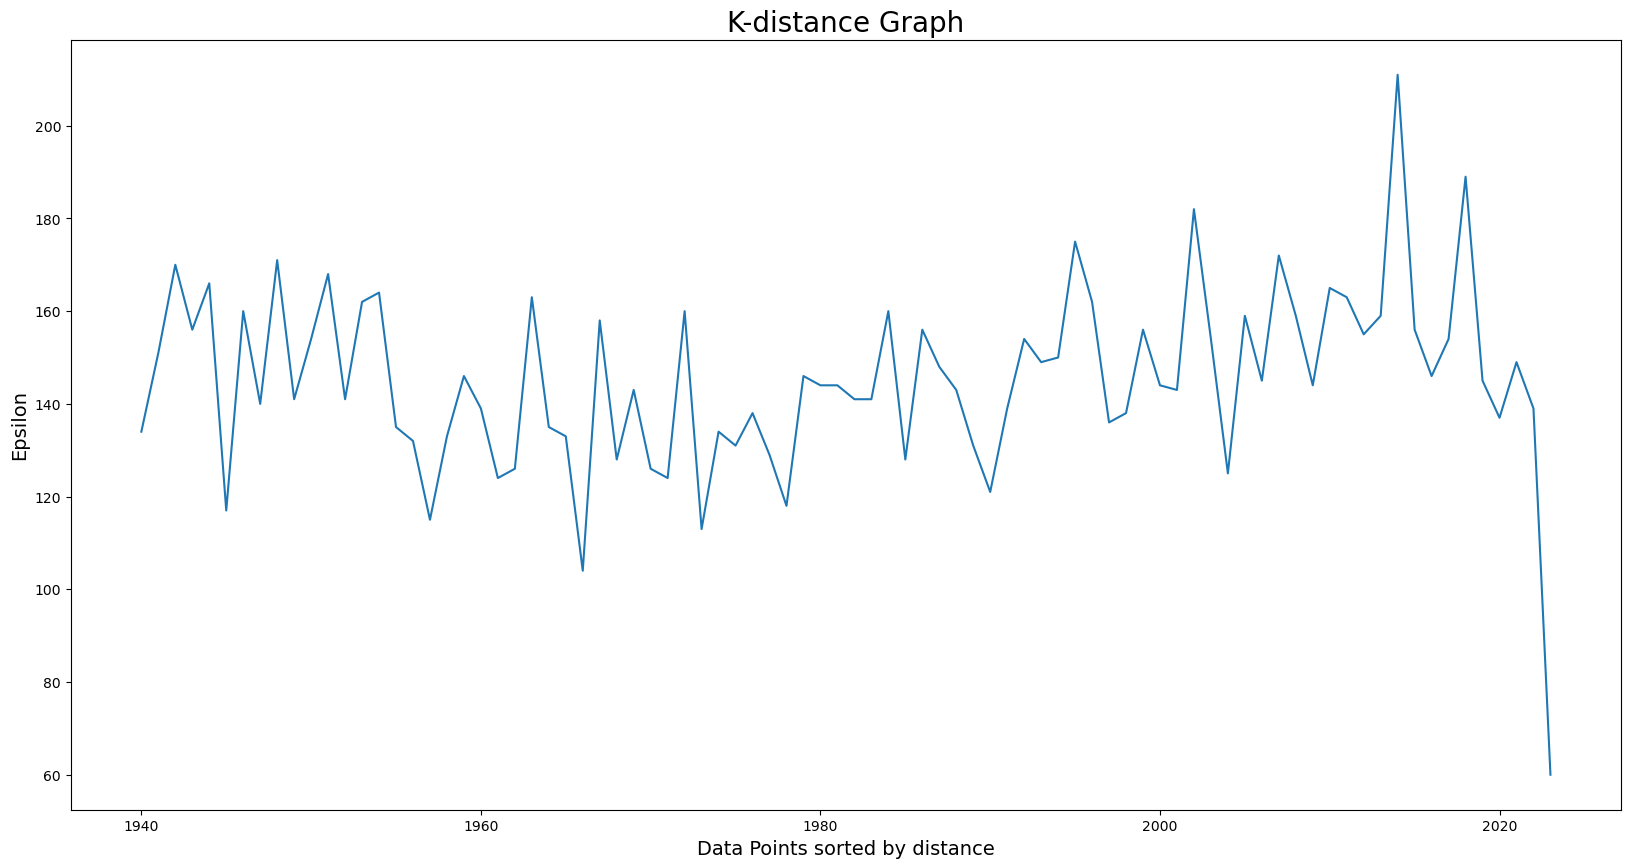

In [467]:
plt.figure(figsize=(20,10))
plt.plot(outliers.iloc[:,-1])
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()